In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch import optim
import albumentations as A
from albumentations.pytorch import ToTensorV2

torch.backends.cudnn.benchmark = True
scaler = torch.cuda.amp.GradScaler()

/Users/silas/work/nest/nest_env/lib/python3.12/site-packages/torch/cuda/amp/grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using {device}")

Using mps


In [3]:
run_test_cases = True # Set to True if debugging is required
cloud_labels = ["Flower", "Gravel", "Fish", "Sugar"] # All possible labels for the clouds

# Original Image resolutions
in_res_y = 1400
in_res_x = 2100

# New Image resolutions
new_res_y = 512
new_res_x = 768

# data directories
test_dir = "./test_images"
train_dir = "./train_images"

# Training params
num_filters = 24 # Number of filters in first conv layer  
num_train_images = 128
num_test_images = 32

batch_size = 1
num_epochs = 40
lr = 1e-4

In [4]:
image_names = os.listdir(train_dir)

# remove broken images
def find_broken_images(img_dir):
    broken = []
    for f in os.listdir(img_dir):
        path = os.path.join(img_dir, f)
        img = cv2.imread(path)
        if img is None:
            broken.append(f)
    return broken

broken_train = find_broken_images("./train_images")
broken_test = find_broken_images("./test_images")

print("Broken train images:", broken_train)
print("Broken test images:", broken_test)

# Remove them from your image list
image_names = [f for f in image_names if f not in broken_train]

train_images = image_names[:num_train_images]
test_images = image_names[num_train_images:num_train_images+num_test_images]
print(test_images)

df = pd.read_csv('train.csv')
df[['Image', 'Label']] = df['Image_Label'].str.split('_', expand=True)

if run_test_cases:
    print(df[['Image', 'Label', 'EncodedPixels']].head(8))
    print()
    print(df['Image'].unique()[:10])

Broken train images: []
Broken test images: []
['af4d36b.jpg', 'ebe596d.jpg', '423c22d.jpg', '61259d9.jpg', 'bacd6fe.jpg', '1230c60.jpg', '4b8a262.jpg', '3614409.jpg', '3361513.jpg', '7473a71.jpg', 'f431307.jpg', '0e42958.jpg', '4e5b275.jpg', 'a1d13fa.jpg', '57559fb.jpg', 'df426c2.jpg', '6e1e7cb.jpg', 'a00ab01.jpg', '5e70a5b.jpg', '6d9de9e.jpg', 'd836ac5.jpg', '19807b1.jpg', '5683db4.jpg', '40dd239.jpg', '87a1831.jpg', 'fa12d07.jpg', '741dcf3.jpg', 'e3b3009.jpg', '2d2bd73.jpg', 'd2eb9fe.jpg', 'de2c9bb.jpg', 'cea2726.jpg']
         Image   Label                                      EncodedPixels
0  0011165.jpg    Fish  264918 937 266318 937 267718 937 269118 937 27...
1  0011165.jpg  Flower  1355565 1002 1356965 1002 1358365 1002 1359765...
2  0011165.jpg  Gravel                                                NaN
3  0011165.jpg   Sugar                                                NaN
4  002be4f.jpg    Fish  233813 878 235213 878 236613 878 238010 881 23...
5  002be4f.jpg  Flower  1339

In [5]:
# Get labels and rle from image name
def get_labels_rle(image_name: str, df) -> list:
    rles = df[df['Image'] == image_name]['EncodedPixels'].to_list()
    labels = df[df['Image'] == image_name]['Label'].to_list()
    return rles, labels

# Debugging
if run_test_cases:

    # Get Files
    train_images = os.listdir(train_dir)[:2]
    print(f"Train images: {train_images}")

    for image in train_images:
        rles, labels = get_labels_rle(f"{image}", df)
        for rle, label in zip(rles, labels):
            print(f"Label: {label} \n rle: {rle} \n")

Train images: ['8734e73.jpg', '0ece863.jpg']
Label: Fish 
 rle: nan 

Label: Flower 
 rle: 642862 632 644262 632 645662 632 647062 632 648462 632 649862 632 651262 632 652662 632 654062 632 655462 632 656862 632 658262 632 659662 632 661062 632 662462 632 663862 632 665262 632 666662 632 668062 632 669462 632 670862 632 672262 632 673662 632 675062 632 676462 632 677862 632 679262 632 680662 632 682062 632 683462 632 684862 632 686262 632 687662 632 689062 632 690462 632 691862 632 693262 632 694662 632 696062 632 697462 632 698862 632 700262 632 701662 632 703062 632 704462 632 705862 632 707262 632 708662 632 710062 632 711462 632 712862 632 714262 632 715662 632 717062 632 718462 632 719862 632 721262 632 722662 632 724062 632 725462 632 726862 632 728262 632 729662 632 731062 632 732462 632 733862 632 735262 632 736662 632 738062 632 739462 632 740862 632 742262 632 743662 632 745062 632 746462 632 747862 632 749262 632 750662 632 752062 632 753462 632 754862 632 756262 632 757662 

Train images: ['8734e73.jpg', '0ece863.jpg']


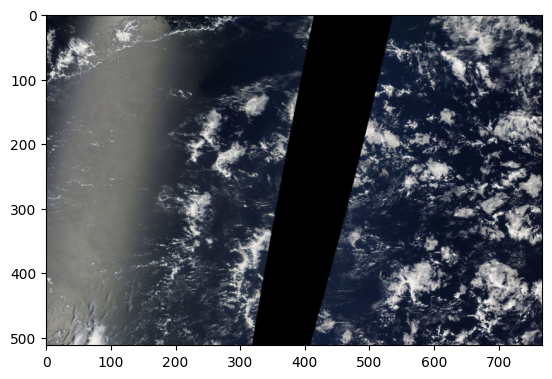

[0.]
titel: Fish


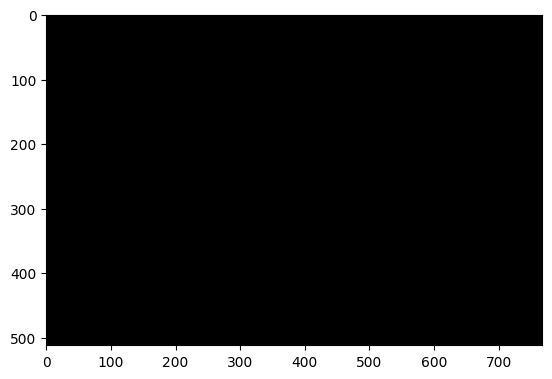

[0. 1.]
titel: Flower


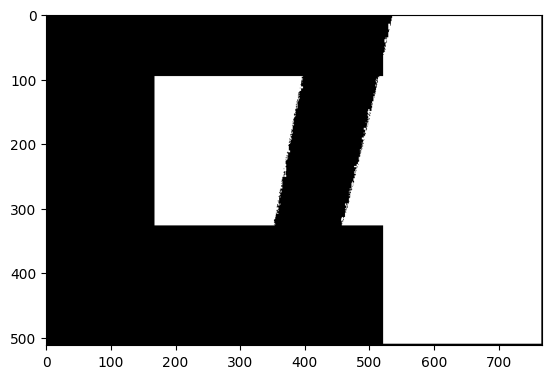

[0.]
titel: Gravel


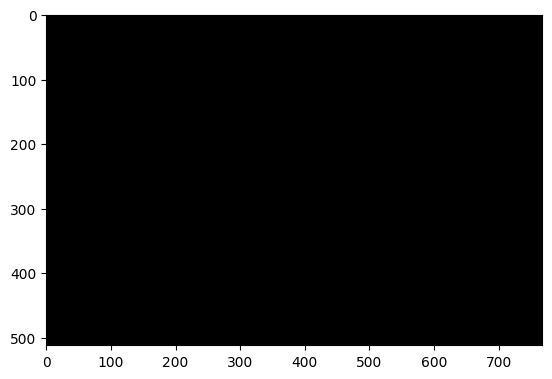

[0.]
titel: Sugar


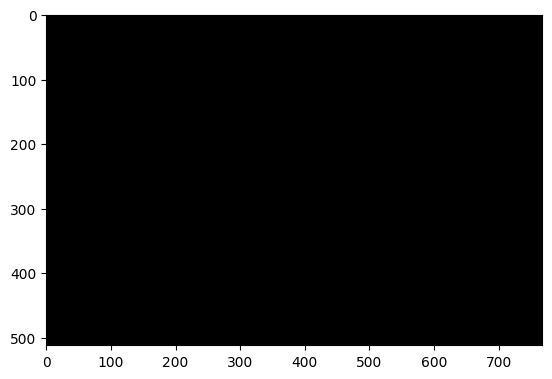

---------------------------------


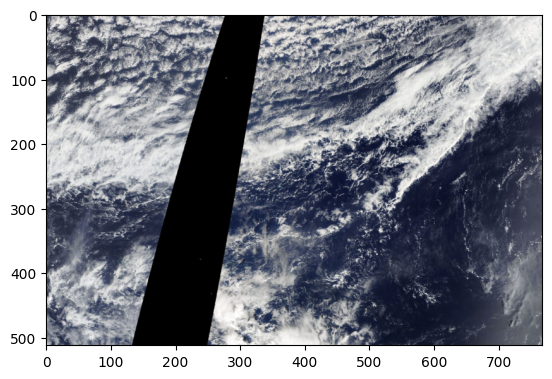

[0.]
titel: Fish


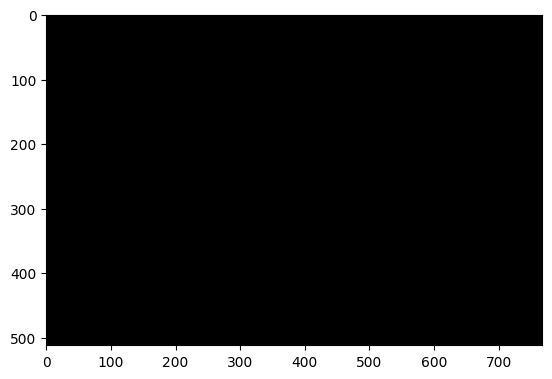

[0.]
titel: Flower


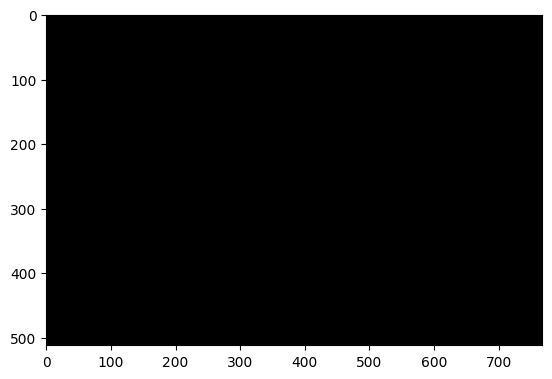

[0. 1.]
titel: Gravel


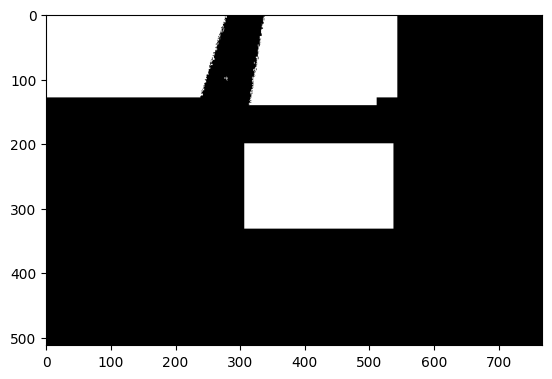

[0. 1.]
titel: Sugar


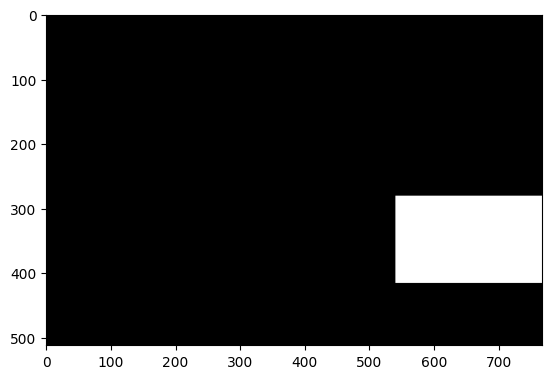

---------------------------------


In [6]:
# Convert rle mask encoding into 2D arrays
def rle_to_array(rle_list: list) -> np.array:

    # Create empty array for
    array = np.zeros(in_res_y * in_res_x)

    # Skip if cloud formation is not on picture
    if not rle_list or pd.isna(rle_list):
        mask = array.reshape((in_res_x, in_res_y), order="A").T
        return mask
    
    rle_array = np.array(list(map(int, rle_list.split())), dtype=int)
    start_pixels = rle_array[::2] - 1 # Offset because pixel 1 is arr position 0
    num_pixels = rle_array[1::2]

    # Create 2D mask
    for start_pixel, num_pixels in zip(start_pixels, num_pixels): # Format is [start_idx_0, num_pixels_0 ...]
        array[start_pixel:start_pixel+num_pixels] = 1.0
    
    # Reshape
    mask = array.reshape((in_res_x, in_res_y), order="A").T # 2D array of [Height, Width]

    return mask

# For debugging
if run_test_cases:

    # Get Files
    train_images = os.listdir(train_dir)[:2]
    print(f"Train images: {train_images}")

    # Plot files
    for image_name in train_images:
        img = cv2.imread(f"{train_dir}/{image_name}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (new_res_x, new_res_y), interpolation=cv2.INTER_AREA)

        rles, labels = get_labels_rle(image_name, df)

        # Raw Image
        plt.imshow(img)
        plt.show()

        for rle, label in zip(rles, labels):

            # Masked Image
            mask = rle_to_array(rle)
            mask = cv2.resize(mask, (new_res_x, new_res_y), interpolation=cv2.INTER_NEAREST)
            print(np.unique(mask))
            print(f"titel: {label}")
            plt.imshow(mask, cmap="grey", vmin=0.0, vmax=1.0)
            #plt.imshow(mask[:, :, None].repeat(3, axis=-1)*img, cmap="grey", vmin=0.0, vmax=1.0)
            plt.show()
        print("---------------------------------")

In [7]:
def dice_coef(preds, target, eps=1e-6):
    # [B, 4, H, W]

    preds = torch.sigmoid(preds)
    overlap = (preds * target).sum((2,3))

    dice = (2. * overlap + eps) / (preds.sum((2,3)) + target.sum((2,3)) + eps)

    return dice.mean()

In [8]:
def dice_loss(preds, target, eps=1e-6):
    return 1 - dice_coef(preds, target, eps=eps)

In [9]:
bce_loss = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([5.0]).to(device))

In [10]:
def loss_fn(preds, target, eps=1e-6):
    return 0.25 * dice_loss(preds, target, eps) + 0.75 * bce_loss(preds, target)

In [11]:
train_transform = A.Compose([
    # --- geometric transforms ---
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    #A.Transpose(p=0.2),

    # --- photometric transforms ---
    A.RandomBrightnessContrast(p=0.1),
    #A.GaussNoise(p=0.2),
    A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=10, val_shift_limit=10, p=0.2),

    # --- spatial transforms ---
    A.ShiftScaleRotate(
        shift_limit=0.02,
        scale_limit=0.05,
        rotate_limit=10,
        border_mode=cv2.BORDER_REFLECT,
        p=0.3
    ),

    # --- normalization ---
    A.Normalize(mean=(0.485, 0.456, 0.406), 
                std=(0.229, 0.224, 0.225)),

    # --- ensure correct shape ---
    A.Resize(height=new_res_y, width=new_res_x, always_apply=True),

    # --- to tensor ---
    ToTensorV2(),
])

val_transform = A.Compose([
    # --- normalization ---
    A.Normalize(mean=(0.485, 0.456, 0.406), 
                std=(0.229, 0.224, 0.225)),

    # --- ensure correct shape ---
    A.Resize(height=new_res_y, width=new_res_x, always_apply=True),

    # --- to tensor ---
    ToTensorV2(),
])



/Users/silas/work/nest/nest_env/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/var/folders/31/lhm9rkfd5mq5nqs778m806v40000gn/T/ipykernel_65491/3775102026.py:27: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  A.Resize(height=new_res_y, width=new_res_x, always_apply=True),
/var/folders/31/lhm9rkfd5mq5nqs778m806v40000gn/T/ipykernel_65491/3775102026.py:39: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  A.Resize(height=new_res_y, width=new_res_x, always_apply=True),


In [12]:
class ImageDataset(Dataset):
    def __init__(self, data_frame, img_dir, image_names, transform=None):
        self.img_dir = img_dir
        self.image_names = image_names
        self.data_frame = data_frame
        self.transform = transform

    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, idx): 
        image_name = self.image_names[idx]

        # --- Load image ---
        image = cv2.imread(f"{self.img_dir}/{image_name}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # --- Downsample image ---
        image = cv2.resize(image, (new_res_x, new_res_y), interpolation=cv2.INTER_AREA)
        image = image.astype(np.float32)

        rles, _ = get_labels_rle(image_name, self.data_frame)

        # --- Create mask ---
        mask = np.zeros((4, in_res_y, in_res_x), dtype=np.float32)
        for i, rle in enumerate(rles):
            single_mask = rle_to_array(rle)
            mask[i, :, :] = single_mask

        # --- Downsample mask per channel ---
        mask_resized = np.zeros((4, new_res_y, new_res_x), dtype=np.float32)
        for i in range(4):
            mask_resized[i, :, :] = cv2.resize(
                    mask[i],
                    (new_res_x, new_res_y),
                    interpolation=cv2.INTER_NEAREST
                )
        mask = mask_resized

        # --- Transformations ---
        if self.transform:
            transformed = self.transform(
                image=image,
                mask=mask.transpose(1, 2, 0)
            )
            image = transformed["image"]
            mask = transformed["mask"].permute(2, 0, 1)  # [C, H, W]
        else:
            # manually convert only if no transform applied
            image = torch.from_numpy(image).permute(2, 0, 1).float()
            mask = torch.from_numpy(mask).float()

        return image, mask


In [13]:
class ConvolutionBlock(nn.Module):
    def __init__(self, in_channels, out_channels, conv_kernel_size, padding):
        super().__init__()

        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, conv_kernel_size, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, conv_kernel_size, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
            )

    def forward(self, x):
        output = self.conv_block(x)
        return output # [batch, out_channels, H_out, W_out]


In [14]:
class PoolBlock(nn.Module):
    def __init__(self, downsample):
        super().__init__()

        self.pool = nn.MaxPool2d(downsample)

    def forward(self, x):
        output = self.pool(x)
        return output

In [15]:
class UpSampleBlock(nn.Module):
    def __init__(self, channels, upsample):
        super().__init__()

        self.up_sample_block = nn.Sequential(
            nn.Upsample(scale_factor=upsample, mode='bilinear', align_corners=False),
            nn.Conv2d(channels, channels // upsample, kernel_size=1)
        )

    def forward(self, x):
        upsample_block = self.up_sample_block(x)
        return upsample_block

In [16]:
class Network(nn.Module):
    def __init__(self, filters):
        super().__init__()

        # in_channels, out_channels, conv_kernel_size, padding, pool_kernel_size
        self.encoder_layer_0 = ConvolutionBlock(3, filters, 3, 1)
        self.encoder_layer_1 = ConvolutionBlock(filters, 2*filters, 3, 1)
        self.encoder_layer_2 = ConvolutionBlock(2*filters, 4*filters, 3, 1)

        self.pool_block_0 = PoolBlock(downsample=2)
        self.pool_block_1 = PoolBlock(downsample=2)
        self.pool_block_2 = PoolBlock(downsample=2)

        self.bottle_neck = nn.Conv2d(4*filters, 8*filters, 3, padding=1)

        # in_channels, out_channels, conv_kernel_size, stride
        self.decoder_layer_2 = ConvolutionBlock(8*filters, 4*filters, 3, 1)
        self.decoder_layer_1 = ConvolutionBlock(4*filters, 2*filters, 3, 1)
        self.decoder_layer_0 = ConvolutionBlock(2*filters, filters, 3, 1)

        self.up_sample_block2 = UpSampleBlock(8 * filters, upsample=2)
        self.up_sample_block1 = UpSampleBlock(4 * filters, upsample=2)
        self.up_sample_block0 = UpSampleBlock(2 * filters, upsample=2)

        self.output_layer = nn.Conv2d(filters, 4, 1)

    def forward(self, x): # [Batch, Color, Height, Width]
        
        enc0 = self.encoder_layer_0(x) # [B, num_filters, H, W]
        pool0 = self.pool_block_0(enc0) # [B, num_filters, H / 2, W / 2]

        enc1 = self.encoder_layer_1(pool0) # [B, 2 * num_filters, H / 2, W / 2]
        pool1 = self.pool_block_1(enc1) # [B, 2 * num_filters, H / 4, W / 4]

        enc2 = self.encoder_layer_2(pool1) # [B, 4 * num_filters, H / 4, W / 4]
        pool2 = self.pool_block_2(enc2) # [B, 4 * num_filters, H / 8, W / 8]

        bottle_neck = self.bottle_neck(pool2) # [B, 4 * num_filters, H / 4, W / 4]

        up2 = self.up_sample_block2(bottle_neck) # [B, 4 * num_filters, H / 4, W / 4]
        concat2 = torch.cat([up2, enc2], dim=1) # [B, 8 * num_filters, H / 4, W / 4]
        dec2 = self.decoder_layer_2(concat2) # [B, 4 * num_filters, H / 4, W / 4]

        up1 = self.up_sample_block1(dec2) # [B, 2 * num_filters, H / 2, W / 2]
        concat1 = torch.cat([up1, enc1], dim=1) # [B, 4 * num_filters, H / 2, W / 2]
        dec1 = self.decoder_layer_1(concat1) # [B, 2 * num_filters, H / 2, W / 2]

        up0 = self.up_sample_block0(dec1) # [B, num_filters, H, W]
        concat0 = torch.cat([up0, enc0], dim=1) # [B, 2 * num_filters, H, W]
        dec0 = self.decoder_layer_0(concat0) # [B, num_filters, H, W]

        logits = self.output_layer(dec0) # [B, 4, H, W]

        return logits

In [17]:
# Datasets and DataLoader
train_dataset = ImageDataset(df, train_dir, train_images, transform=train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=0)

test_dataset = ImageDataset(df, train_dir, test_images, transform=val_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=0)

In [18]:
model = Network(num_filters).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

image


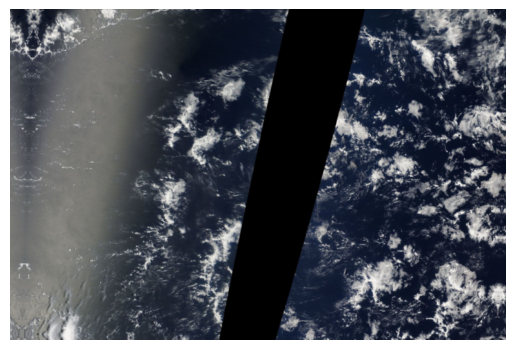

image


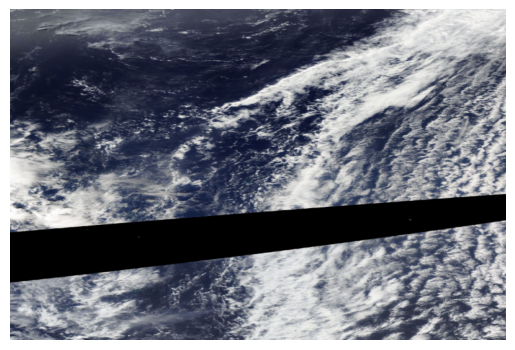

In [19]:
# Albumentations ImageNet stats
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

def denormalize(img_tensor):
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    img = std * img + mean  # undo normalization
    img = np.clip(img, 0, 1)
    return img

if run_test_cases:

    for image, mask in train_dataloader:
        # Move batch tensors to device
        image, mask = image.to(device), mask.to(device)

        # Loop over images in the batch
        for img, msk in zip(image, mask):
            # Convert tensor -> NumPy for display

            print("image")
            plt.imshow(denormalize(img))
            plt.axis('off')
            plt.show()

            """
            for m in msk:
                print("mask")
                plt.imshow(m.cpu().numpy(), cmap="grey", vmin=0.0, vmax=1.0)
                plt.show()
            """

In [20]:
# Training loop
for epoch in range(num_epochs):

    # Training
    model.train()
    train_loss = 0.0
    
    for image, mask in train_dataloader:
        image, mask = image.to(device), mask.to(device)

        with torch.cuda.amp.autocast():
            preds = model(image)
            loss = loss_fn(preds, mask)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
    train_loss /= len(train_dataloader)

    # Validation
    model.eval()
    val_loss = 0.0
    dice = 0.0

    with torch.no_grad():
        for image, mask in test_dataloader:
            image, mask = image.to(device), mask.to(device)

            preds = model(image)
            loss = loss_fn(preds, mask)

            val_loss += loss.item()

            hard_preds = torch.where(F.sigmoid(preds) > 0.5, 1.0, 0.0)
            dice += dice_coef(hard_preds, mask)
        val_loss /= len(test_dataloader)
        dice /= len(test_dataloader)

    # Print metrics
    print(f"Epoch: {epoch}")
    print(f"Train loss: {train_loss:.4f}")
    print(f"Val loss: {val_loss:.4f}")
    print(f"Dice coefficient: {dice:.4f}")
    print()

/Users/silas/work/nest/nest_env/lib/python3.12/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch: 0
Train loss: 0.9311
Val loss: 1.0405
Dice coefficient: 0.1787

Epoch: 1
Train loss: 0.9303
Val loss: 1.0399
Dice coefficient: 0.1786

Epoch: 2
Train loss: 0.9253
Val loss: 1.0390
Dice coefficient: 0.1778

Epoch: 3
Train loss: 0.9291
Val loss: 1.0390
Dice coefficient: 0.1781

Epoch: 4
Train loss: 0.9024
Val loss: 1.0383
Dice coefficient: 0.1788

Epoch: 5
Train loss: 0.9108
Val loss: 1.0386
Dice coefficient: 0.1794

Epoch: 6
Train loss: 0.8859
Val loss: 1.0378
Dice coefficient: 0.1797

Epoch: 7
Train loss: 0.8799
Val loss: 1.0369
Dice coefficient: 0.1797

Epoch: 8
Train loss: 0.8782
Val loss: 1.0361
Dice coefficient: 0.1793

Epoch: 9
Train loss: 0.8683
Val loss: 1.0354
Dice coefficient: 0.1790

Epoch: 10
Train loss: 0.8808
Val loss: 1.0357
Dice coefficient: 0.1791

Epoch: 11
Train loss: 0.8573
Val loss: 1.0348
Dice coefficient: 0.1791

Epoch: 12
Train loss: 0.8522
Val loss: 1.0340
Dice coefficient: 0.1793

Epoch: 13
Train loss: 0.8473
Val loss: 1.0336
Dice coefficient: 0.1798

Ep